# Experiment Tracking with MLFlow (Local)

In this demo we will see how to use MLFlow for tracking experiments, using a toy data set. In the attached lab (below), you will download a larger dataset and attempt to train the best model that you can.

We should first install mlflow, and add it to the requirements.txt file if not done already.

`pip install mlflow` or `python3 -m pip install mlflow`.

You may also need to `pip install setuptools`.

From here, make sure to save this notebook in a specific folder, and ensure you run all command line commands from the same folder.

In [1]:
import mlflow
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_wine
from sklearn.metrics import accuracy_score

After loading the libraries, we can first check the mlflow version you have. And, just for fun, let's look at the mlflow UI by running `mlflow ui`. After this, we should do two things:
- set the tracking uri
- create or set the experiment

Setting the tracking uri tells mlflow where to save the results of our experiments. We will first save these locally in a sqlite instance. In a future lab we will set up mlflow to run in GCP.

If you've already created an experiment previously that you'd like to use, you can tell mlflow by setting the experiment. You can also use `set_experiment` even if the experiment has not yet been created - mlflow will first check if the experiment exists, and if not, it will create it for you. 

In [2]:
mlflow.__version__

'2.15.1'

Running the below code will create a sqlite database and an mlruns folder in the current directory.

In [3]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('demo-experiment')

2025/03/24 20:59:25 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/03/24 20:59:25 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/Users/napo/USF/Sp25.2/Ml_Ops/mlruns/1', creation_time=1742875165765, experiment_id='1', last_update_time=1742875165765, lifecycle_stage='active', name='demo-experiment', tags={}>

From here, we can load the wine data from sklearn and take a look at it. Then let's play around with some models, without using mlflow for now, to get a sense of why mlflow might come in handy.

In [4]:
wine = load_wine()
df_wine = pd.DataFrame(data=wine.data, columns=wine.feature_names)
df_wine.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0


In [5]:
y = wine.target
X = df_wine
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X, y)

DecisionTreeClassifier(max_depth=4)

In [6]:
accuracy_score(y, dt.predict(df_wine))

0.9887640449438202

## Train a Model Using MLFLow

In this section, let's train a simple decision tree model, where we will now adjust the maximum depth (`max_depth`) of the tree, and save the results of each run of the experiment using mlflow. To do so, we need to tell mlflow to start recording. We do this with `start_run`. 

The things we might want to record in this simple case are:
- the value of `max_depth`
- the corresponding accuracy of the model

We can also tag each run to make it easier to identify them later.

After running the below code, be sure to check the mlflow UI by running the following in the terminal from the same directory as where you saved this notebook:

`mlflow ui` note that just running this you will not see any of your experiments. You must specify the uri (the place where all of your results are being stored)

`mlflow ui --backend-store-uri sqlite:///mlflow.db`

In [7]:
with mlflow.start_run():
    # log parameters and log metrics
    # parameters: hyperparameters
    # metrics: model performance metrics

    mlflow.set_tags({"Model":"decision-tree", "Train Data": "all-data"})

    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X, y)
    acc = accuracy_score(y, dt.predict(df_wine))

    mlflow.log_param("max_depth", tree_depth)
    mlflow.log_metric("accuracy", acc)

mlflow.end_run()

Let's do it again, but this time we'll use a random forest, which has some other hyperparameters we can tune, which makes keeping track of things a little more complex without a tool like mlflow.

In [8]:
from sklearn.ensemble import RandomForestClassifier

with mlflow.start_run():
    mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

    ntree = 1000
    mtry = 4

    mlflow.log_params({'n_estimators':ntree, 'max_features':mtry})

    rf = RandomForestClassifier(n_estimators = ntree, max_features = mtry, oob_score = True)
    rf.fit(X,y)
    acc = rf.oob_score_
    #acc = accuracy_score(y, rf.predict(X))
    mlflow.log_metric('accuracy', acc)

mlflow.end_run()

Typically, in a real-world scenario, you wouldn't change your parameter values manually and re-run your code, you would either use a loop to loop through different parameter values, or you'd use a built-in method for doing cross-validation, of which there are a few. First, let's use a simple loop to run the experiment multiple times, and save the results of each run.

In [9]:
ntrees = [20,40,60,80,100]
mtrys = [3,4,5]
for i in ntrees:
    for j in mtrys:
        with mlflow.start_run():
            mlflow.set_tags({"Model":"random-forest", "Train Data": "all-data"})

            mlflow.log_params({'n_estimators':i, 'max_features':j})

            rf = RandomForestClassifier(n_estimators = i, max_features = j, oob_score = True)
            rf.fit(X,y)
            acc = rf.oob_score_
            #acc = accuracy_score(y, rf.predict(X))
            mlflow.log_metric('accuracy', acc)
        mlflow.end_run()

## Training a Model with mlflow and hyperopt

One way of tuning your model is to use the `hyperopt` library. `hyperopt` is a library that does hyperparameter tuning, and does so in a way that makes it easy for mlflow to keep track of the results. 

First, install the libraries you don't have, and then load them below. We do not use `hyperopt` much in the class, so if you don't want to add it to your requirements.txt file, you don't have to.

For this exercise, we'll split the data into training and validation, and then we'll train decision trees and random forests and use `hyperopt` to do the hyperparameter tuning and find the best model for us.

In [11]:
! pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached py4j-0.10.9.9-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
Using cached future-1.0.0-py3-none-any.whl (491 kB)
Using cached py4j-0.10.9.9-py2.py3-none-any.whl (203 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [12]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

From the above we will use `cross_val_score` for our metric, `fmin` is used by `hyperopt` to do the tuning, `tpe` (Tree of Parzen Estimators) is the algorithm used to search the hyperparameter space,  `hp` has methods we need to use for defining our search space, `STATUS_OK` is a status message that each run completed, and `Trials` keeps track of each run.

In [13]:
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}

search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()

In [14]:
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

100%|██████████| 32/32 [00:14<00:00,  2.27trial/s, best loss: -0.9833333333333332]


In [15]:
best_result

{'classifier_type': 1,
 'criterion': 1,
 'rf_max_features': 2,
 'rf_n_estimators': 469}

### Using Autologging

Rather than manually logging parameters and metrics, mlflow has an autolog feature, which is compatible with a subset of python libraries, such as sklearn. Autologging makes it easy to log all of the important stuff, without having to manually write lines of code to log the parameters. However, sometimes you will want to have finer control over what gets logged, and should instead skip autologging.

In [16]:

with mlflow.start_run():
    mlflow.sklearn.autolog()
    tree_depth = 5
    dt = DecisionTreeClassifier(max_depth=tree_depth)
    dt.fit(X_train, y_train)
    mlflow.sklearn.autolog(disable=True)
mlflow.end_run()

# Artifact Tracking and Model Registry (Local)

In this section we will save some artifacts from our model as we go through the model development process. There are a few things that might be worth saving, such as datasets, plots, and the final model itself that might go into production later.

## Data

First, let's see how we can store our important datasets, in a compressed format, for use for later, for example, in case we get a new request about our model and need to run some analyses (such as "what is the distribution of this feature, but only for this specific subset of data?" or "how did the model do on these particular observations from your validation set?").

In [17]:
import os 

os.makedirs('save_data', exist_ok = True)

X_train.to_parquet('save_data/x_train.parquet')

mlflow.log_artifact('save_data/x_train.parquet')

In [18]:
X_test.to_parquet('save_data/x_test.parquet')

mlflow.log_artifacts('save_data/')

You can now go to the mlflow UI, click on the latest run, and select the Artifacts tab. You should see something similar to this:
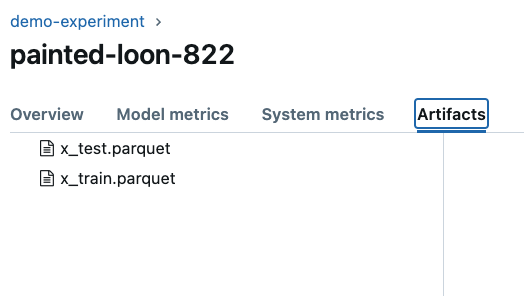

## Images

As part of the model dev process you may end up creating visualizations that can be useful for analysis, or for reporting. You can use mlflow to log the important ones and ignore the rest. After creating the below figure, save into a folder called images, and then you can log whatever is in the `images` folder as an artifact.

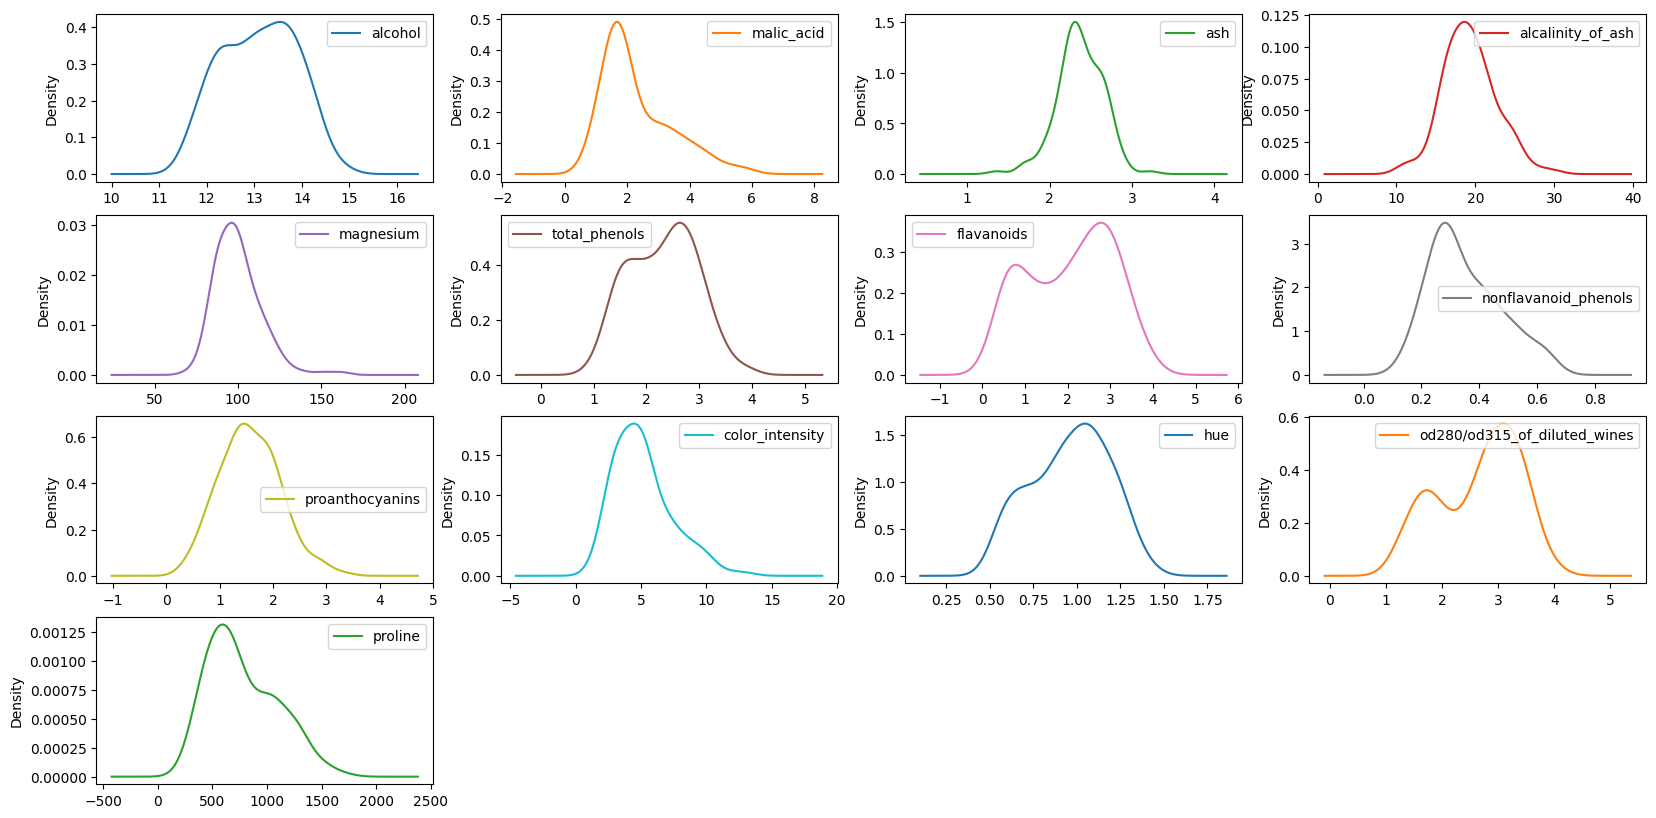

In [22]:
# %matplotlib inline
# os.makedirs('images', exist_ok = True)
# X_train.plot.density(subplots = True, figsize = (20,10), layout = (4,4), sharey = False, sharex = False)

import os
import matplotlib.pyplot as plt

%matplotlib inline

# Ensure the folder exists
os.makedirs('images', exist_ok=True)

# Generate density plots
X_train.plot.density(
    subplots=True, 
    figsize=(20, 10), 
    layout=(4, 4), 
    sharey=False, 
    sharex=False
)

# Save the plot
plt.savefig('images/density_plot.png', dpi=300, bbox_inches='tight')

# Optional: Show the plot (if not already visible)
plt.show()

In [23]:
mlflow.log_artifacts('images')
mlflow.end_run()

Notice how all of the artifacts were saved in the same run of the experiment. We could have added an `mlflow.end_run()` in between our `log_artifacts` lines to separate runs if we wanted to.

## Model Management and Model Registry

As you are developing your models you may want to save certain versions of the model, or maybe even all of them, so that you don't have to go back and retrain them later. We can do this in mlflow by logging the models, not as artifacts, but as models, using `log_model`. 

In this section we'll log a couple of models to see how mlflow handles model management. Above, we used `hyperopt` to train a bunch of models at once. Let's do this again, and log some of the models that we train.

### Logging as an Artifact

First we can try logging a model as an artifact. To do this, we must first save the model itself, which we can do by using the `pickle` library. We then log the model as an artifact like we did with data and images. 

In [24]:
import pickle

os.makedirs('../models', exist_ok = True)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

with open('../models/model.pkl','wb') as f:
    pickle.dump(dt,f)

# First we'll log the model as an artifact
mlflow.log_artifact('../models/model.pkl', artifact_path='my_models')

### Logging as a Model

Logging the model as an artifact only logs the pickle file (the serialized version of the model). It's not really very useful, especially since models contain so much metadata that might be critical to know for deploying the model later. mlflow has a built-in way of logging models specifically, so let's see how to use this, and how it's different from logging models as an artifact.

In [25]:
# Let's do it again, but this time we will log the model using log_model
mlflow.sklearn.log_model(dt, artifact_path = 'better_models')
mlflow.end_run()

2025/03/24 21:09:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Ok, so if you go to the mlflow UI at this point you can see the difference in `log_artifact`, which simply logs the pickle file, and `log_model`, which also gives you information about the environment, required packages, and model flavor.

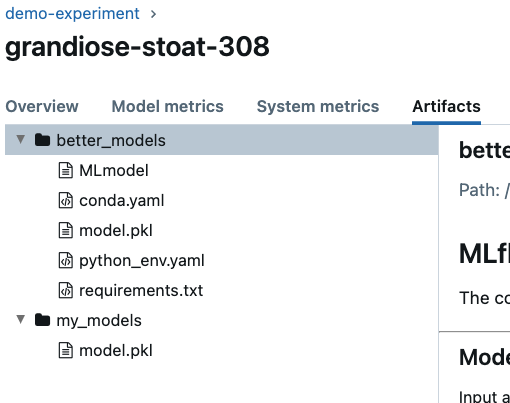

Let's do this one more time, but this time let's use `hyperopt` and log all of the trained models separately. Let's do this in a new experiment called 'demo-experiment2'. 

In [26]:
mlflow.set_experiment('demo-experiment2')
def objective(params):
    with mlflow.start_run():
        classifier_type = params['type']
        del params['type']
        if classifier_type == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif classifier_type == 'rf':
            clf = RandomForestClassifier(**params)        
        else:
            return 0
        acc = cross_val_score(clf, X, y).mean()

        mlflow.set_tag("Model", classifier_type)
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.sklearn.log_model(clf, artifact_path = 'better_models')
        mlflow.end_run()
        return {'loss': -acc, 'status': STATUS_OK}
search_space = hp.choice('classifier_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 20, 500),
        'max_features': hp.randint('rf_max_features', 2,9),
        'criterion': hp.choice('criterion', ['gini', 'entropy'])
    },
])

algo = tpe.suggest
trials = Trials()
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

2025/03/24 21:10:34 INFO mlflow.tracking.fluent: Experiment with name 'demo-experiment2' does not exist. Creating a new experiment.


  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2025/03/24 21:10:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  3%|▎         | 1/32 [00:02<01:03,  2.05s/trial, best loss: -0.9607936507936508]

2025/03/24 21:10:38 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  6%|▋         | 2/32 [00:03<00:48,  1.63s/trial, best loss: -0.9607936507936508]

2025/03/24 21:10:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



  9%|▉         | 3/32 [00:04<00:45,  1.57s/trial, best loss: -0.9720634920634922]

2025/03/24 21:10:41 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 12%|█▎        | 4/32 [00:06<00:43,  1.54s/trial, best loss: -0.9720634920634922]

2025/03/24 21:10:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 16%|█▌        | 5/32 [00:07<00:41,  1.53s/trial, best loss: -0.9720634920634922]

2025/03/24 21:10:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 19%|█▉        | 6/32 [00:09<00:44,  1.70s/trial, best loss: -0.9777777777777779]

2025/03/24 21:10:46 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 22%|██▏       | 7/32 [00:11<00:44,  1.77s/trial, best loss: -0.9777777777777779]

2025/03/24 21:10:47 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 25%|██▌       | 8/32 [00:13<00:38,  1.59s/trial, best loss: -0.9777777777777779]

2025/03/24 21:10:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 28%|██▊       | 9/32 [00:15<00:40,  1.76s/trial, best loss: -0.9777777777777779]

2025/03/24 21:10:51 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 31%|███▏      | 10/32 [00:16<00:36,  1.66s/trial, best loss: -0.9777777777777779]

2025/03/24 21:10:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 34%|███▍      | 11/32 [00:18<00:37,  1.76s/trial, best loss: -0.9777777777777779]

2025/03/24 21:10:55 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 38%|███▊      | 12/32 [00:20<00:36,  1.82s/trial, best loss: -0.9777777777777779]

2025/03/24 21:10:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 41%|████      | 13/32 [00:22<00:35,  1.85s/trial, best loss: -0.9777777777777779]

2025/03/24 21:10:59 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 44%|████▍     | 14/32 [00:24<00:33,  1.87s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:00 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 47%|████▋     | 15/32 [00:25<00:28,  1.69s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 50%|█████     | 16/32 [00:27<00:26,  1.67s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 53%|█████▎    | 17/32 [00:29<00:25,  1.73s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 56%|█████▋    | 18/32 [00:30<00:22,  1.59s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:06 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 59%|█████▉    | 19/32 [00:31<00:19,  1.49s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:08 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 62%|██████▎   | 20/32 [00:33<00:18,  1.55s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 66%|██████▌   | 21/32 [00:35<00:18,  1.67s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 69%|██████▉   | 22/32 [00:37<00:17,  1.78s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:13 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 72%|███████▏  | 23/32 [00:38<00:15,  1.68s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:15 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 75%|███████▌  | 24/32 [00:40<00:12,  1.62s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 78%|███████▊  | 25/32 [00:42<00:12,  1.85s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:18 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 81%|████████▏ | 26/32 [00:43<00:09,  1.66s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 84%|████████▍ | 27/32 [00:45<00:08,  1.63s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 88%|████████▊ | 28/32 [00:46<00:06,  1.53s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 91%|█████████ | 29/32 [00:48<00:04,  1.64s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 94%|█████████▍| 30/32 [00:49<00:03,  1.52s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:26 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



 97%|█████████▋| 31/32 [00:51<00:01,  1.52s/trial, best loss: -0.9777777777777779]

2025/03/24 21:11:27 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.



100%|██████████| 32/32 [00:52<00:00,  1.66s/trial, best loss: -0.9777777777777779]


### Loading Models

Now that models have been logged, you can load specific models back into python for predicting and further analysis. There are two main ways to do this. The mlflow UI actually gives you some instructions, with code that you copy and paste.

In [27]:
logged_model = 'runs:/112c107761bc4fdba4452010904abad9/better_models' #replace with one of your models

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: better_models
  flavor: mlflow.sklearn
  run_id: 112c107761bc4fdba4452010904abad9

In [28]:
sklearn_model = mlflow.sklearn.load_model(logged_model)
sklearn_model

RandomForestClassifier(max_features=2, n_estimators=158)

In [29]:
sklearn_model.fit(X_train, y_train)
preds = sklearn_model.predict(X_test)
preds[:5]

array([1, 1, 1, 2, 0])

### Model Registry

Typically, you will **register** your *chosen* model, the model you plan to put into production. But, sometimes, after you've chosen and registered a model, you may need to replace that model with a new version. For example, the model may have gone into production and started to degrade in performance, and so the model needed to be retrained. Or, you go to deploy your model and notice an error or bug, and now have to go back and retrain it.

In this section let's see how we take our logged models and register them in the model registry, which then can get picked up by the production process, or engineer, for deployment. First, I'll demonstrate how this is done within the UI, but then below I'll show how we can use the python API to do the same thing.

In [30]:
runid = '112c107761bc4fdba4452010904abad9'
mod_path = f'runs:/{runid}/artifacts/better_models'
mlflow.register_model(model_uri = mod_path, name = 'wine_model_from_nb')

Successfully registered model 'wine_model_from_nb'.
Created version '1' of model 'wine_model_from_nb'.


<ModelVersion: aliases=[], creation_timestamp=1742876000513, current_stage='None', description=None, last_updated_timestamp=1742876000513, name='wine_model_from_nb', run_id='112c107761bc4fdba4452010904abad9', run_link=None, source='/Users/napo/USF/Sp25.2/Ml_Ops/mlruns/2/112c107761bc4fdba4452010904abad9/artifacts/artifacts/better_models', status='READY', status_message=None, tags={}, user_id=None, version=1>

## Common Issues

- Nothing is appearing in the MLFlow UI: make sure you start the UI from the directory where your notebook is running.  
- I installed a library, but I'm getting an error loading it: be sure you installed it in the same environment as where your notebook is running.  
- MLFlow doesn't seem to be working at all, I'm just getting errors all over the place: this might be a versioning issue.  
- The UI broke, I can't get back to it: `sudo lsof -i :5000 | awk '{print $2}' | tail -n +2 | xargs kill`



# Experiment Tracking and Model Registry Lab

## Overview

In this lab you will each download a new dataset and attempt to train a good model, and use mlflow to keep track of all of your experiments, log your metrics, artifacts and models, and then register a final set of models for "deployment", though we won't actually deploy them anywhere yet.

## Goal

Your goal is **not** to become a master at MLFlow - this is not a course on learning all of the ins and outs of MLFlow. Instead, your goal is to understand when and why it is important to track your model development process (tracking experiments, artifacts and models) and to get into the habit of doing so, and then learn at least the basics of how MLFlow helps you do this so that you can then compare with other tools that are available.

## Data

You can choose your own dataset to use here. It will be helpful to choose a dataset that is already fairly clean and easy to work with. You can even use a dataset that you've used in a previous course. We will do a lot of labs where we do different things with datasets, so if you can find one that is interesting enough for modeling, it should work for most of the rest of the course. 

There are tons of places where you can find open public datasets. Choose something that interests you, but don't overthink it.

[Kaggle Datasets](https://www.kaggle.com/datasets)  
[HuggingFace Datasets](https://huggingface.co/docs/datasets/index)  
[Dagshub Datasets](https://dagshub.com/datasets/)  
[UCI](https://archive.ics.uci.edu/ml/datasets.php)  
[Open Data on AWS](https://registry.opendata.aws/)  
[Yelp](https://www.yelp.com/dataset)  
[MovieLens](https://grouplens.org/datasets/movielens/)  
And so many more...

## Instructions

Once you have selected a set of data, create a brand new experiment in MLFlow and begin exploring your data. Do some EDA, clean up, and learn about your data. You do not need to begin tracking anything yet, but you can if you want to (e.g. you can log different versions of your data as you clean it up and do any feature engineering). Do not spend a ton of time on this part. Your goal isn't really to build a great model, so don't spend hours on feature engineering and missing data imputation and things like that.

Once your data is clean, begin training models and tracking your experiments. If you intend to use this same dataset for your final project, then start thinking about what your model might look like when you actually deploy it. For example, when you engineer new features, be sure to save the code that does this, as you will need this in the future. If your final model has 1000 complex features, you might have a difficult time deploying it later on. If your final model takes 15 minutes to train, or takes a long time to score a new batch of data, you may want to think about training a less complex model.

Now, when tracking your experiments, at a *minimum*, you should:

1. Try at least 3 different ML algorithms (e.g. linear regression, decision tree, random forest, etc.).
2. Do hyperparameter tuning for **each** algorithm.
3. Do some very basic feature selection, and repeat the above steps with these reduced sets of features.
4. Identify the top 3 best models and note these down for later.
6. Choose the **final** "best" model that you would deploy or use on future data, stage it (in MLFlow), and run it on the test set to get a final measure of performance. Don't forget to log the test set metric.
7. Be sure you logged the exact training, validation, and testing datasets for the 3 best models, as well as hyperparameter values, and the values of your metrics.  
8. Push your code to Github. No need to track the mlruns folder, the images folder, any datasets, or the sqlite database in git.

### Turning It In

In the MLFlow UI, next to the refresh button you should see three vertical dots. Click the dots and then download your experiments as a csv file. Open the csv file in Excel and highlight the rows for your top 3 models from step 4, highlight the run where you applied your best model to the test set, and then save as an excel file. Take a snapshot of the Models page in the MLFLow UI showing the model you staged in step 6 above. Submit the excel file and the snapshot to Canvas.

In [38]:
df_3 = pd.read_csv('MrBeast_youtube_stats.csv')
df_3 = df_3[['duration_seconds', 'viewCount', 'likeCount', 'commentCount']]
df_3 = df_3.fillna(df_3.mean(numeric_only=True))
df_3

X_3 = df_3.drop('viewCount', axis=1)
y_3 = df_3['viewCount']


In [39]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_3, y_3, test_size=0.2, shuffle=True)

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from hyperopt import hp, tpe, fmin, STATUS_OK, Trials
import mlflow
import mlflow.sklearn


In [41]:
mlflow.set_experiment('demo-experiment3')

# def objective(params):
#     with mlflow.start_run():
#         classifier_type = params['type']
#         del params['type']
#         if classifier_type == 'dt':
#             clf = DecisionTreeClassifier(**params)
#         elif classifier_type == 'rf':
#             clf = RandomForestClassifier(**params)        
#         else:
#             return 0
#         acc = cross_val_score(clf, X, y).mean()

#         mlflow.set_tag("Model", classifier_type)
#         mlflow.log_params(params)
#         mlflow.log_metric("accuracy", acc)
#         mlflow.end_run()
#         return {'loss': -acc, 'status': STATUS_OK}

def objective(params):
    with mlflow.start_run():
        model_type = params['type']
        del params['type']

        if model_type == 'dt':
            model = DecisionTreeRegressor(**params)
        elif model_type == 'rf':
            model = RandomForestRegressor(**params)
        elif model_type == 'lr':
            model = LinearRegression()  # no hyperparams to tune here
        else:
            return {'loss': float('inf'), 'status': STATUS_OK}

        # Use negative MSE (since Hyperopt minimizes loss)
        score = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5).mean()
        rmse = (-score) ** 0.5

        mlflow.set_tag("Model", model_type)
        mlflow.log_params(params)
        mlflow.log_metric("RMSE", rmse)

        return {'loss': rmse, 'status': STATUS_OK}

# search_space = hp.choice('classifier_type', [
#     {
#         'type': 'dt',
#         'criterion': hp.choice('dtree_criterion', ['gini', 'entropy']),
#         'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1,10)]),
#         'min_samples_split': hp.randint('dtree_min_samples_split', 2,10)
#     },
#     {
#         'type': 'rf',
#         'n_estimators': hp.randint('rf_n_estimators', 20, 500),
#         'max_features': hp.randint('rf_max_features', 2,9),
#         'criterion': hp.choice('criterion', ['gini', 'entropy'])
#     },
# ])

search_space = hp.choice('regressor_type', [
    {
        'type': 'dt',
        'criterion': hp.choice('dtree_criterion', ['squared_error', 'friedman_mse']),
        'max_depth': hp.choice('dtree_max_depth', [None, hp.randint('dtree_max_depth_int', 1, 10)]),
        'min_samples_split': hp.randint('dtree_min_samples_split', 2, 10)
    },
    {
        'type': 'rf',
        'n_estimators': hp.randint('rf_n_estimators', 50, 300),
        'max_features': hp.choice('rf_max_features', ['sqrt', 'log2']),
        'criterion': hp.choice('rf_criterion', ['squared_error', 'absolute_error'])
    },
    {
        'type': 'lr'  # LinearRegression has no hyperparams in most cases
    }
])


algo = tpe.suggest
trials = Trials()

2025/03/24 21:32:54 INFO mlflow.tracking.fluent: Experiment with name 'demo-experiment3' does not exist. Creating a new experiment.


In [42]:
best_result = fmin(
        fn=objective, 
        space=search_space,
        algo=algo,
        max_evals=32,
        trials=trials)

100%|██████████| 32/32 [00:08<00:00,  3.60trial/s, best loss: 0.281767564088979]  


In [43]:
best_result

{'regressor_type': 1,
 'rf_criterion': 1,
 'rf_max_features': 1,
 'rf_n_estimators': 161}

In [ ]:
# runid = '662e864e70ba4dd4b1585c8646b9ebef'
# mod_path = f'runs:/{runid}/artifacts/better_models'
# mlflow.register_model(model_uri = mod_path, name = 'best_mrBeast_model_from_nb')

In [ ]:
# logged_model = 'runs:/662e864e70ba4dd4b1585c8646b9ebef/better_models' #replace with one of your models

# # Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)
# loaded_model

In [ ]:
# sklearn_model = mlflow.sklearn.load_model(logged_model)
# sklearn_model

In [ ]:
# from sklearn.metrics import mean_squared_error
# sklearn_model.fit(X_train, y_train)
# preds = sklearn_model.predict(X_test)
# preds[:5]
# mse = mean_squared_error(y_test, preds)
# rmse = mse ** 0.5
# print(f"Test RMSE: {rmse}")

In [ ]:
# with mlflow.start_run(run_name="Final Test Evaluation"):
#     mlflow.set_tag("stage", "test")
#     mlflow.set_tag("model_source", "best_mrBeast_model_from_nb")
#     mlflow.log_metric("final_test_rmse", rmse)


In [44]:
runid = '662e864e70ba4dd4b1585c8646b9ebef'
mod_path = f'runs:/{runid}/artifacts/better_models'

# Register model (if not already done)
mlflow.register_model(model_uri=mod_path, name='best_mrBeast_model_from_nb')

# Load model from the run
logged_model = f'runs:/{runid}/better_models'

# Load trained model (do NOT fit again!)
sklearn_model = mlflow.sklearn.load_model(logged_model)

# Predict on test data
from sklearn.metrics import mean_squared_error

preds = sklearn_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = mse ** 0.5
print(f"Test RMSE: {rmse:.4f}")

# Log test RMSE in a new run
with mlflow.start_run(run_name="Final Test Evaluation"):
    mlflow.set_tag("stage", "test")
    mlflow.set_tag("model_source", "best_mrBeast_model_from_nb")
    mlflow.log_metric("final_test_rmse", rmse)


Successfully registered model 'best_mrBeast_model_from_nb'.
Created version '1' of model 'best_mrBeast_model_from_nb'.


OSError: No such file or directory: '/Users/napo/USF/Sp25.2/Ml_Ops/mlruns/3/662e864e70ba4dd4b1585c8646b9ebef/artifacts/better_models'

In [46]:
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from sklearn.metrics import mean_squared_error

# runid = '662e864e70ba4dd4b1585c8646b9ebef'
# mod_path = f'runs:/{runid}/artifacts/better_models'

# # Register model (if not already done)
# mlflow.register_model(model_uri=mod_path, name='best_mrBeast_model_from_nb')

# # Load model from the run
# logged_model = f'runs:/{runid}/better_models'

# # Load trained model (do NOT fit again!)
# sklearn_model = mlflow.sklearn.load_model(logged_model)

# STEP 1: Log the trained model (if not already done)
with mlflow.start_run(run_name="manual_log_best_model"):
    mlflow.sklearn.log_model(sklearn_model, artifact_path="better_models")
    run_id = mlflow.active_run().info.run_id
    print("Logged model under run ID:", run_id)

# STEP 2: Register the model
model_uri = f"runs:/{run_id}/better_models"
model_name = "best_mrBeast_model_from_nb"

result = mlflow.register_model(model_uri=model_uri, name=model_name)
version = result.version
print(f"Model registered as version: {version}")

# STEP 3: Transition model to 'Staging'
client = MlflowClient()
client.transition_model_version_stage(
    name=model_name,
    version=version,
    stage="Staging",
    archive_existing_versions=True
)

# STEP 4: Load the model from the registry
sklearn_model = mlflow.sklearn.load_model(f"models:/{model_name}/Staging")

# STEP 5: Predict on test data
preds = sklearn_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
rmse = mse ** 0.5
print(f"Test RMSE: {rmse:.4f}")

# STEP 6: Log final test RMSE
with mlflow.start_run(run_name="Final Test Evaluation"):
    mlflow.set_tag("stage", "test")
    mlflow.set_tag("model_source", model_name)
    mlflow.set_tag("model_version", version)
    mlflow.log_metric("final_test_rmse", rmse)


2025/03/24 22:09:36 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Logged model under run ID: 873eda548c3a491287529ad65a511a94
Model registered as version: 2
Test RMSE: 0.1667


Registered model 'best_mrBeast_model_from_nb' already exists. Creating a new version of this model...
Created version '2' of model 'best_mrBeast_model_from_nb'.
/var/folders/dw/48_x4sbj0pz94vfwp1s43ynm0000gn/T/ipykernel_51624/2766800365.py:34: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(
/opt/anaconda3/envs/mlops/lib/python3.12/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.o

In [47]:
with mlflow.start_run(run_name="Best Model 1"):

    # 🔹 1. Log datasets as artifacts
    os.makedirs("tmp_data", exist_ok=True)
    pd.DataFrame(X_train).to_csv("tmp_data/X_train.csv", index=False)
    pd.DataFrame(X_test).to_csv("tmp_data/X_test.csv", index=False)
    pd.DataFrame(y_train).to_csv("tmp_data/y_train.csv", index=False)
    pd.DataFrame(y_test).to_csv("tmp_data/y_test.csv", index=False)

    mlflow.log_artifact("tmp_data/X_train.csv", artifact_path="data")
    mlflow.log_artifact("tmp_data/X_test.csv", artifact_path="data")
    mlflow.log_artifact("tmp_data/y_train.csv", artifact_path="data")
    mlflow.log_artifact("tmp_data/y_test.csv", artifact_path="data")

    # 🔹 2. Log hyperparameters
    mlflow.log_params(sklearn_model.get_params())

    # 🔹 3. Train (if not trained) and log model
    sklearn_model.fit(X_train, y_train)
    mlflow.sklearn.log_model(sklearn_model, artifact_path="model")

    # 🔹 4. Evaluate and log metrics
    preds_train = sklearn_model.predict(X_train)
    preds_test = sklearn_model.predict(X_test)

    metrics = {
        "train_rmse": mean_squared_error(y_train, preds_train) ** 0.5,
        "test_rmse": mean_squared_error(y_test, preds_test) ** 0.5
    }

    mlflow.log_metrics(metrics)

    print("Logged model, data, and metrics to MLflow.")

2025/03/24 22:15:45 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Logged model, data, and metrics to MLflow.


In [45]:
from mlflow.tracking import MlflowClient

run_id = "662e864e70ba4dd4b1585c8646b9ebef"
client = MlflowClient()

artifacts = client.list_artifacts(run_id)
for artifact in artifacts:
    print(artifact.path)


runid = '112c107761bc4fdba4452010904abad9'
mod_path = f'runs:/{runid}/artifacts/better_models'
mlflow.register_model(model_uri = mod_path, name = 'wine_model_from_nb')